#  Pretraining with TorchTitan

This tutorial is designed for [AMD Developer Cloud](https://www.amd.com/en/developer/resources/cloud-access/amd-developer-cloud.html) users who have access to a single-node environment, for example, an 8-GPU system.
It demonstrates an end‑to‑end, single‑box training workflow using the TorchTitan AMD fork on ROCm.

**What you’ll learn**

How to:

- Set up a clean single-node training environment.
- Launch TorchTitan on a mixture of experts (MoE) configuration and understand the key flags.
- Monitor the logs and verify the run.

**TorchTitan**

TorchTitan is a compact proof of concept that demonstrates the newest native PyTorch-distributed APIs.
The AMD fork adds full ROCm support and experimental Primus-Turbo `FP8` kernels.
This tutorial uses the `dev/primus_turbo` branch of the [AMD-AGI/torchtitan-amd](https://github.com/AMD-AGI/torchtitan-amd) repository.

**The model**
 
DeepSeek‑MoE 16B Base (with approximately 16.4B parameters) is an MoE LLM with fine‑grained experts and shared‑expert isolation.
The Hugging Face model card is [deepseek-moe-16b-base](https://huggingface.co/deepseek-ai/deepseek-moe-16b-base).

**The goal**

Obtain a successful single‑node run with clear logging and checks, so you can confidently scale or swap datasets later.


## Prerequisites

This tutorial was developed and tested using the following setup.

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu 22.04.

### Hardware

* **AMD Instinct™ GPUs**: This tutorial was validated on an AMD Instinct MI300X node (with 8 GPUs). Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.3 or later**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

   ``` bash
   rocm-smi
   ```

   This command lists your AMD GPUs with relevant details, similar to the image below.

   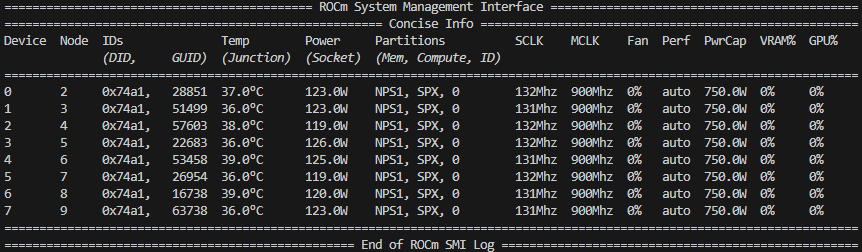
  
* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:
   

   ``` bash
   docker run hello-world
   ```

## Prepare the training environment

To set up your training environment, follow these steps:

### 1. Pull the Docker image

Ensure your system meets the [ROCm system requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

Pull the Docker image required for this tutorial:

``` bash
docker pull docker.io/rocm/primus:v25.9_gfx942
```

### 2. Launch the Docker container

Launch the Docker container and map the necessary directories.

``` bash
docker run -it --rm \
  --name torchtitan_tutorial \
  --device /dev/dri --device /dev/kfd \
  --network host --ipc host --group-add video \
  --cap-add SYS_PTRACE --security-opt seccomp=unconfined --privileged \
  -v "$PWD":/workspace \
  -w /workspace \
  --entrypoint /bin/bash \
  docker.io/rocm/primus:v25.9_gfx942
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).

### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter lab --ip=127.0.0.1 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.

### 4. Set up the environment

Now, set up the environment using single‑node defaults by disabling InfiniBand (IB) and clearing the Slurm variables.

In [2]:
import os

# --- export env vars ---
os.environ["NCCL_SOCKET_IFNAME"] = "lo"
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ.pop("SLURM_MASTER_ADDR", None)
os.environ.pop("SLURM_MASTER_PORT", None)

# --- verify ---
print("NCCL_SOCKET_IFNAME =", os.environ["NCCL_SOCKET_IFNAME"])
print("NCCL_IB_DISABLE =", os.environ["NCCL_IB_DISABLE"])

### 5. Clone and install TorchTitan and Primus-Turbo inside the container

Use Git to clone the TorchTitan AMD fork (or update it, if it already exists) and checkout the `Primus-Turbo` branch.

In [3]:
%%bash
set -euo pipefail

if [ -d "torchtitan-amd/.git" ]; then
  echo "[info] Repo exists: torchtitan-amd"
else
  echo "[info] Cloning https://github.com/AMD-AIG-AIMA/torchtitan-amd.git ..."
  git clone "https://github.com/AMD-AIG-AIMA/torchtitan-amd.git"
fi

cd torchtitan-amd
git checkout dev/primus_turbo


Create per‑host build caches for the AITER and PyTorch extensions to avoid permission collisions between users.

In [4]:
import os
import socket
from pathlib import Path

# --- unset env vars  ---
os.environ.pop("AITER_JIT_DIR", None)
os.environ.pop("TORCH_EXTENSIONS_DIR", None)

# --- hostname  ---
host_name = socket.gethostname()

# --- build dir ---
tmp_build_dir = Path("/workspace/torchtitan-amd/3rdparty/build") / host_name
tmp_build_dir.mkdir(parents=True, exist_ok=True)   # like `mkdir -p ...`

# --- export env vars ---
os.environ["AITER_JIT_DIR"] = str(tmp_build_dir / "single_aiter_cache")
os.environ["TORCH_EXTENSIONS_DIR"] = str(tmp_build_dir / "torch_extensions")

# --- verify ---
print("AITER_JIT_DIR =", os.environ["AITER_JIT_DIR"])
print("TORCH_EXTENSIONS_DIR =", os.environ["TORCH_EXTENSIONS_DIR"])

Install TorchTitan inside the container.

In [5]:
%%bash
set -euo pipefail

cd torchtitan-amd

pip install -r requirements.txt
pip install torchao
pip install -e .

Install Primus-Turbo from the wheel.

In [6]:
%%bash
set -euo pipefail

cd torchtitan-amd

pip uninstall numpy -y && pip install numpy==1.26.4
pip3 install --extra-index-url https://test.pypi.org/simple ./3rdparty/primus_turbo-0.1.0+dbeaf79-cp310-cp310-linux_x86_64.whl

### 6. Download the DeepSeekMoE 16B base model

Download the `deepseek-ai/deepseek-moe-16b-base` model from Hugging Face:

In [ ]:
%%bash
set -euo pipefail

cd torchtitan-amd
python scripts/download_hf_assets.py --repo_id deepseek-ai/deepseek-moe-16b-base --assets tokenizer

## Create the training configuration

Follow these steps to create a configuration file to train the model.

### 1. Create a working copy of the TOML configuration file

Create a working copy of the base configuration file for the DeepSeekMoE 16B model.

In [8]:
import pathlib, shutil

repo_dir = pathlib.Path("torchtitan-amd")

override_dir = repo_dir / "run_configs"
override_dir.mkdir(parents=True, exist_ok=True)

base_config_path = repo_dir / "torchtitan/models/deepseek_v3/train_configs/deepseek_v3_16b.toml"
override_config_path = override_dir / "deepseek_v3_16b_local.toml"

shutil.copyfile(base_config_path, override_config_path)

### 2. Modify the file

Install `tomlkit`, a tool for patching the TOML file.

In [9]:
!pip install tomlkit

Next, modify the configuration file to suit your training.
For this tutorial, choose the following settings:

```toml
[profiling]
enable_profiling = false     # Profiling disabled. Enable it if you need the traces.

[training]
local_batch_size = 32        # Edit for a different batch size.
steps = 10                   # Training for only 10 steps. Increase this for real training.
dataset = "c4_test"          # This is a small sample dataset. Use `"c4"` for a real HF dataset.

[parallelism]
expert_parallel_degree = 8   # Edit for a different expert parallel degree.

[checkpoint]
enable = false               # Checkpointing disabled. Enable it for real training.
```

**Optional**: Edit the following block for different configurations. You can modify other fields as well. Review the output from the next cell to see all fields in the configuration file.

In [10]:
import tomlkit

doc = tomlkit.parse(override_config_path.read_text())

# profiling
doc["profiling"]["enable_profiling"]         = False

# training
doc["training"]["local_batch_size"]          = 32
doc["training"]["dataset"]                   = "c4_test"
doc["training"]["steps"]                     = 10

# parallelism
doc["parallelism"]["expert_parallel_degree"] = 8

# checkpoint
doc["checkpoint"]["enable"]                  = False

override_config_path.write_text(tomlkit.dumps(doc))

print("Working config:", str(override_config_path))

View the resulting TOML file:

In [11]:
from IPython.display import Markdown, display

text = override_config_path.read_text()
display(Markdown(f"```toml\n{text}\n```"))

### 3. Set the environment variable

Set the environment variable `CONFIG_FILE` to point to your working copy.

In [12]:
import pathlib, os

config_path = override_config_path.resolve().relative_to(pathlib.Path("/workspace/torchtitan-amd"))

# --- export env vars ---
os.environ["CONFIG_FILE"] = str(config_path)

# --- verify ---
print("CONFIG_FILE =", os.environ["CONFIG_FILE"])

## Pretrain the model

This section explains how to train the model and verify the results.

### 1. Start training

You can now run the training script.
It might take a few minutes for AITER to build. After training starts, it prints metrics for each step.
To verify the results of the run later, save the logs to `logs/dsv3_16b_$(date +%Y%m%d_%H%M%S).log`.

In [13]:
%%bash
set -euo pipefail

cd torchtitan-amd
mkdir -p logs

export PYTHONUNBUFFERED=1
stdbuf -oL -eL ./run_train.sh 2>&1 | tee -a logs/dsv3_16b_$(date +%Y%m%d_%H%M%S).log

### 2. Verify the run results

Finally, you can extract the step, loss, and tokens from logs. You should expect the loss to decrease slightly within the first few steps on the sample data and the tokens to be non-zero.

In [14]:
import re, pathlib, pandas as pd, matplotlib.pyplot as plt

log_dir = pathlib.Path("./torchtitan-amd/logs")  # adjust if needed
log_files = sorted(log_dir.glob("**/*.log")) + sorted(log_dir.glob("**/*.out"))
assert log_files, f"No logs found in {log_dir.resolve()}"
lf = max(log_files, key=lambda p: p.stat().st_mtime)  # newest

# Strip ANSI color codes
ansi_re = re.compile(r"\x1B\[[0-?]*[ -/]*[@-~]")

# Tolerant metrics line (handles commas in numbers and both 'tps' or 'tokens/s')
metrics_re = re.compile(
    r"step:\s*(\d+).*?"
    r"loss:\s*([-\d.eE+]+).*?"
    r"grad_norm:\s*([-\d.eE+]+).*?"
    r"memory:\s*([-\d.eE+]+)GiB\(([-\d.eE+]+)%\).*?"
    r"(?:tps|tokens/s):\s*([\d.,eE+-]+).*?"
    r"tflops:\s*([-\d.eE+]+).*?"
    r"mfu:\s*([-\d.eE+]+)%",
    re.IGNORECASE
)

rows = []
for raw in lf.read_text(errors="ignore").splitlines():
    line = ansi_re.sub("", raw)
    m = metrics_re.search(line)
    if m:
        step = int(m.group(1))
        loss = float(m.group(2))
        grad = float(m.group(3))
        mem_gib = float(m.group(4))
        mem_pct = float(m.group(5))
        tps = float(m.group(6).replace(",", ""))  # remove thousands commas
        tflops = float(m.group(7))
        mfu = float(m.group(8))
        rows.append({
            "step": step, "loss": loss, "grad_norm": grad,
            "mem_gib": mem_gib, "mem_%": mem_pct,
            "tps": tps, "tflops": tflops, "mfu_%": mfu
        })

df = pd.DataFrame(rows).sort_values("step").drop_duplicates("step")
display(df.tail(10))

# Quick health checks
if not df.empty:
    print(f"Steps parsed: {df.step.min()}..{df.step.max()} ({len(df)} points)")
    if len(df) >= 2 and df["loss"].iloc[-1] <= df["loss"].iloc[0]:
        print("✓ Loss decreased at least once — smoke test looks healthy.")
    else:
        print("! Loss didn’t drop yet — tiny sample data can wobble; let a few more steps run.")

# Plots
plt.figure()
plt.plot(df["step"], df["loss"])
plt.xlabel("step"); plt.ylabel("loss"); plt.title("Loss vs step")
plt.show()

plt.figure()
plt.plot(df["step"], df["tps"])
plt.xlabel("step"); plt.ylabel("tokens/sec (tps)"); plt.title("Throughput vs step")
plt.show()

# Optional: confirm training ended
finished = "Training completed" in ansi_re.sub("", lf.read_text(errors="ignore"))
print("Finished flag:", "✓" if finished else "—")
